<a href="https://colab.research.google.com/github/vijji5432/Mental_health_prediction/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("survey.csv")

# Display basic information
print(df.info())

# Check missing values
print(df.isnull().sum())

# Display first few rows
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [2]:
# Drop irrelevant columns
df.drop(columns=['Timestamp', 'state'], inplace=True)

# Fill missing categorical values with mode (most frequent)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Check again for missing values
print(df.isnull().sum())


Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
comments                     0
dtype: int64


<ipython-input-2-c22885aa6659>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-2-c22885aa6659>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [3]:
from sklearn.preprocessing import LabelEncoder

# Label encoding categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


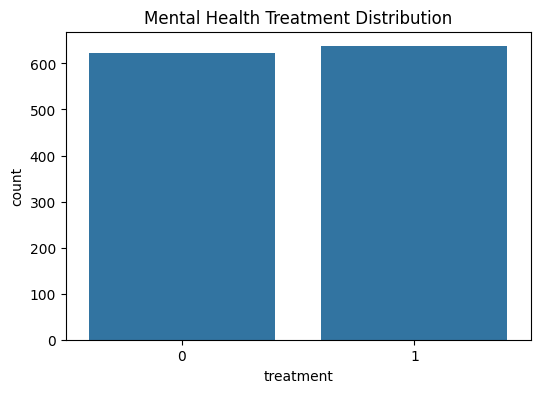

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for mental health treatment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['treatment'])
plt.title("Mental Health Treatment Distribution")
plt.show()


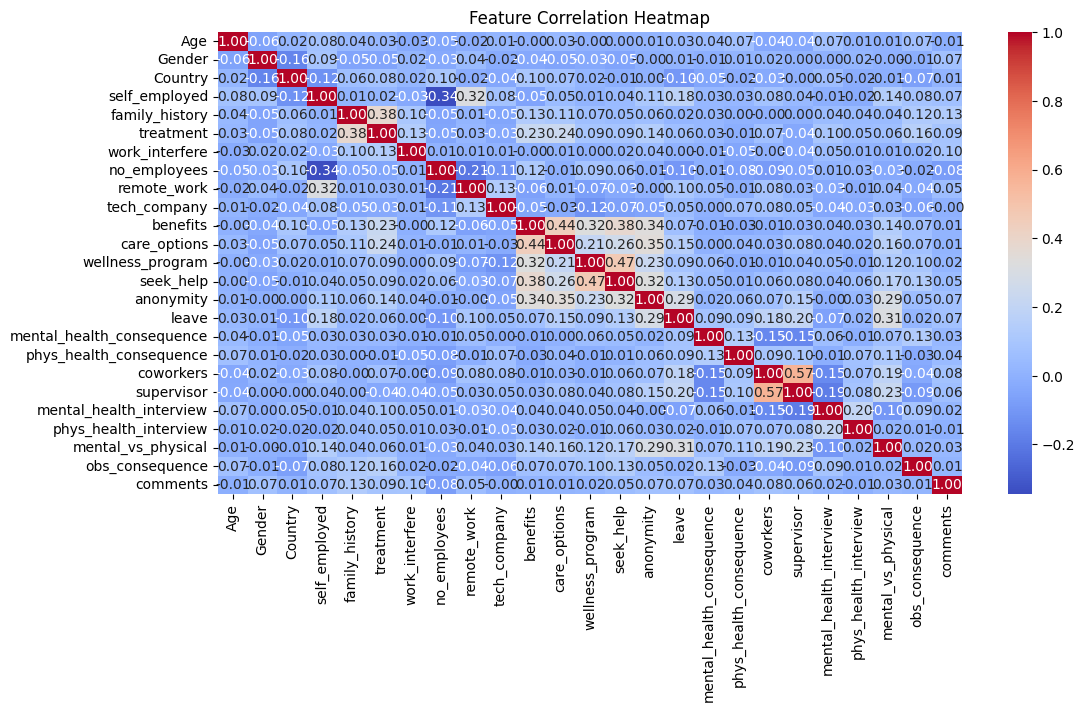

In [5]:
# Correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [6]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X = df.drop(columns=['treatment'])
y = df['treatment']

# Train a Random Forest model for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort in descending order

# Select top 10 features
final_features = X.columns[sorted_indices[:10]]
print("Stable Selected Features (Random Forest):", final_features)



Stable Selected Features (Random Forest): Index(['work_interfere', 'Age', 'family_history', 'care_options', 'Gender',
       'Country', 'no_employees', 'leave', 'benefits',
       'mental_health_consequence'],
      dtype='object')


In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Train a basic Random Forest model
temp_model = RandomForestClassifier(n_estimators=100, random_state=42)
temp_model.fit(X[final_features], y)

# Get feature importances
importances = temp_model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Print feature importance scores
for i in sorted_indices:
    print(f"{final_features[i]}: {importances[i]:.4f}")


Age: 0.1907
work_interfere: 0.1441
family_history: 0.1166
Gender: 0.1020
no_employees: 0.0901
Country: 0.0894
care_options: 0.0803
leave: 0.0723
mental_health_consequence: 0.0598
benefits: 0.0547


In [8]:
print(df['treatment'].value_counts())  # Check label distribution


treatment
1    637
0    622
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

# Keep only selected features
X = df[final_features]  # Use only top 10 features
y = df['treatment']  # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")



Training Data Shape: (1007, 10), Testing Data Shape: (252, 10)


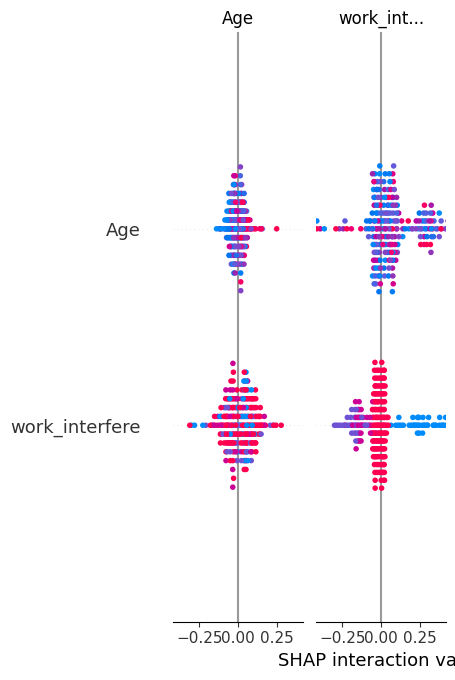

In [10]:
import shap
import pandas as pd

# Ensure X_test is a DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=final_features)

# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(temp_model)
shap_values = explainer.shap_values(X_test_df)

# Summary plot
shap.summary_plot(shap_values, X_test_df)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       129
           1       0.73      0.77      0.75       123

    accuracy                           0.75       252
   macro avg       0.75      0.75      0.75       252
weighted avg       0.75      0.75      0.75       252



In [12]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       129
           1       0.66      0.67      0.67       123

    accuracy                           0.67       252
   macro avg       0.67      0.67      0.67       252
weighted avg       0.67      0.67      0.67       252



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:
from sklearn.metrics import accuracy_score

rf_acc = accuracy_score(y_test, y_pred_rf)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Select best model
best_model = rf_model if rf_acc > xgb_acc else xgb_model
print("Best Model Selected:", "Random Forest" if rf_acc > xgb_acc else "XGBoost")

Random Forest Accuracy: 0.7500
XGBoost Accuracy: 0.6706
Best Model Selected: Random Forest


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Define final feature set
X = df[final_features]
y = df['treatment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Final Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))

# Save the trained model
joblib.dump(rf_model, "mental_health_model.pkl")
print("Final Model Saved Successfully!")


Final Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       129
           1       0.73      0.77      0.75       123

    accuracy                           0.75       252
   macro avg       0.75      0.75      0.75       252
weighted avg       0.75      0.75      0.75       252

Final Model Saved Successfully!
